In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [28]:
# import dataset
df = pd.read_csv("dnd_monsters.csv")
df.head()

,name,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
0,aarakocra,https://www.aidedd.org/dnd/monstres.php?vo=aar...,1/4,humanoid (aarakocra),Medium,12,13,fly,neutral good,NaN,Monster Manual (BR),10.0,14.0,10.0,11.0,12.0,11.0
1,abjurer,NaN,9,humanoid (any race),Medium,12,84,NaN,any alignment,NaN,Volo's Guide to Monsters,NaN,NaN,NaN,NaN,NaN,NaN
2,aboleth,https://www.aidedd.org/dnd/monstres.php?vo=abo...,10,aberration,Large,17,135,swim,lawful evil,Legendary,Monster Manual (SRD),21.0,9.0,15.0,18.0,15.0,18.0
3,abominable-yeti,NaN,9,monstrosity,Huge,15,137,NaN,chaotic evil,NaN,Monster Manual,NaN,NaN,NaN,NaN,NaN,NaN
4,acererak,NaN,23,undead,Medium,21,285,NaN,neutral evil,NaN,Adventures (Tomb of Annihilation),NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# dropping out unncesarry columns
used_columns = ['cr', 'ac', 'hp', 'str', 'dex', 'con', 'int', 'wis', 'cha']
df = df[used_columns]
df

,cr,ac,hp,str,dex,con,int,wis,cha
0,1/4,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23,21,285,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
757,1,11,40,11.0,12.0,11.0,13.0,12.0,14.0
758,22,21,307,NaN,NaN,NaN,NaN,NaN,NaN
759,26,21,580,27.0,24.0,28.0,26.0,27.0,30.0
760,1/4,8,22,13.0,6.0,16.0,3.0,6.0,5.0


In [30]:
# check for nans
nans = dict()
for column in used_columns:
    nans[column] = int(df[column].isna().sum())

nans

{'cr': 1,
 'ac': 0,
 'hp': 0,
 'str': 361,
 'dex': 361,
 'con': 361,
 'int': 361,
 'wis': 361,
 'cha': 361}

In [31]:
# it seems like we have a lot of nans in the attribute scores ([str]ength, [dex]terity, [con]stitution, [int]elligence, [wis]dom, [cha]risma)
# we will be able to check the other 2 things compared to cd (it's overall level):
# ac (armor class, it might have class in the name but it is simply a number showing how hard it is to hit)
# hp (hit points)

# let's check on that 1 missing cr
df[df['cr'].isna()]

,cr,ac,hp,str,dex,con,int,wis,cha
22,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# since it is empty I'll just get rid of it
df = df[df['cr'].isna() == False]

In [33]:
df.head()

,cr,ac,hp,str,dex,con,int,wis,cha
0,1/4,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23,21,285,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# as we can see some of the CR-s is not exactly in number format, as 1/4 and 1/2 exists as CR-s
def cr_standardiser(x) -> float:
    try:
        return float(x)
    except ValueError:
        if x == '1/8':
            return 0.125
        elif x == '1/4':
            return 0.25
        elif x == '1/2':
            return 0.5
        else:
            raise ValueError(f'unexpected value: {x}')

df['cr'] = df['cr'].apply(cr_standardiser)
df.head()

C:\Users\Felhasznalo\AppData\Local\Temp\ipykernel_10448\2159012187.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cr'] = df['cr'].apply(cr_standardiser)


,cr,ac,hp,str,dex,con,int,wis,cha
0,0.25,12,13,10.0,14.0,10.0,11.0,12.0,11.0
1,9.00,12,84,NaN,NaN,NaN,NaN,NaN,NaN
2,10.00,17,135,21.0,9.0,15.0,18.0,15.0,18.0
3,9.00,15,137,NaN,NaN,NaN,NaN,NaN,NaN
4,23.00,21,285,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# let's also split off a smaller database where the NaN str/dex/etc are taken out, let's name it df_s(mall)
df_s = df[df['str'].isna() == False]
# we don't shouldn't have to do more as usually where one is missing the whole line is
nans = dict()
for column in used_columns:
    nans[column] = int(df_s[column].isna().sum())

nans

{'cr': 0,
 'ac': 0,
 'hp': 0,
 'str': 0,
 'dex': 0,
 'con': 0,
 'int': 0,
 'wis': 0,
 'cha': 0}

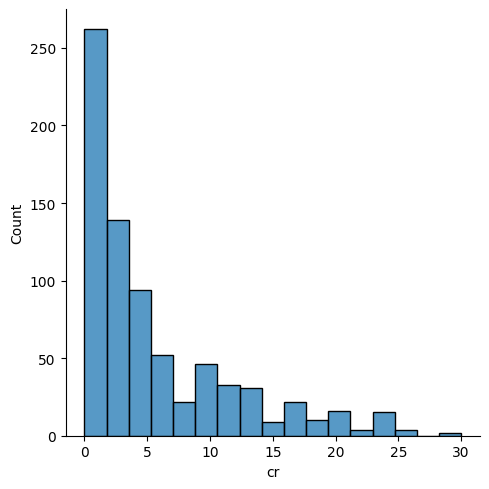

In [35]:
# now that that is done

# let's see our cr mix
sns.displot(df['cr'])

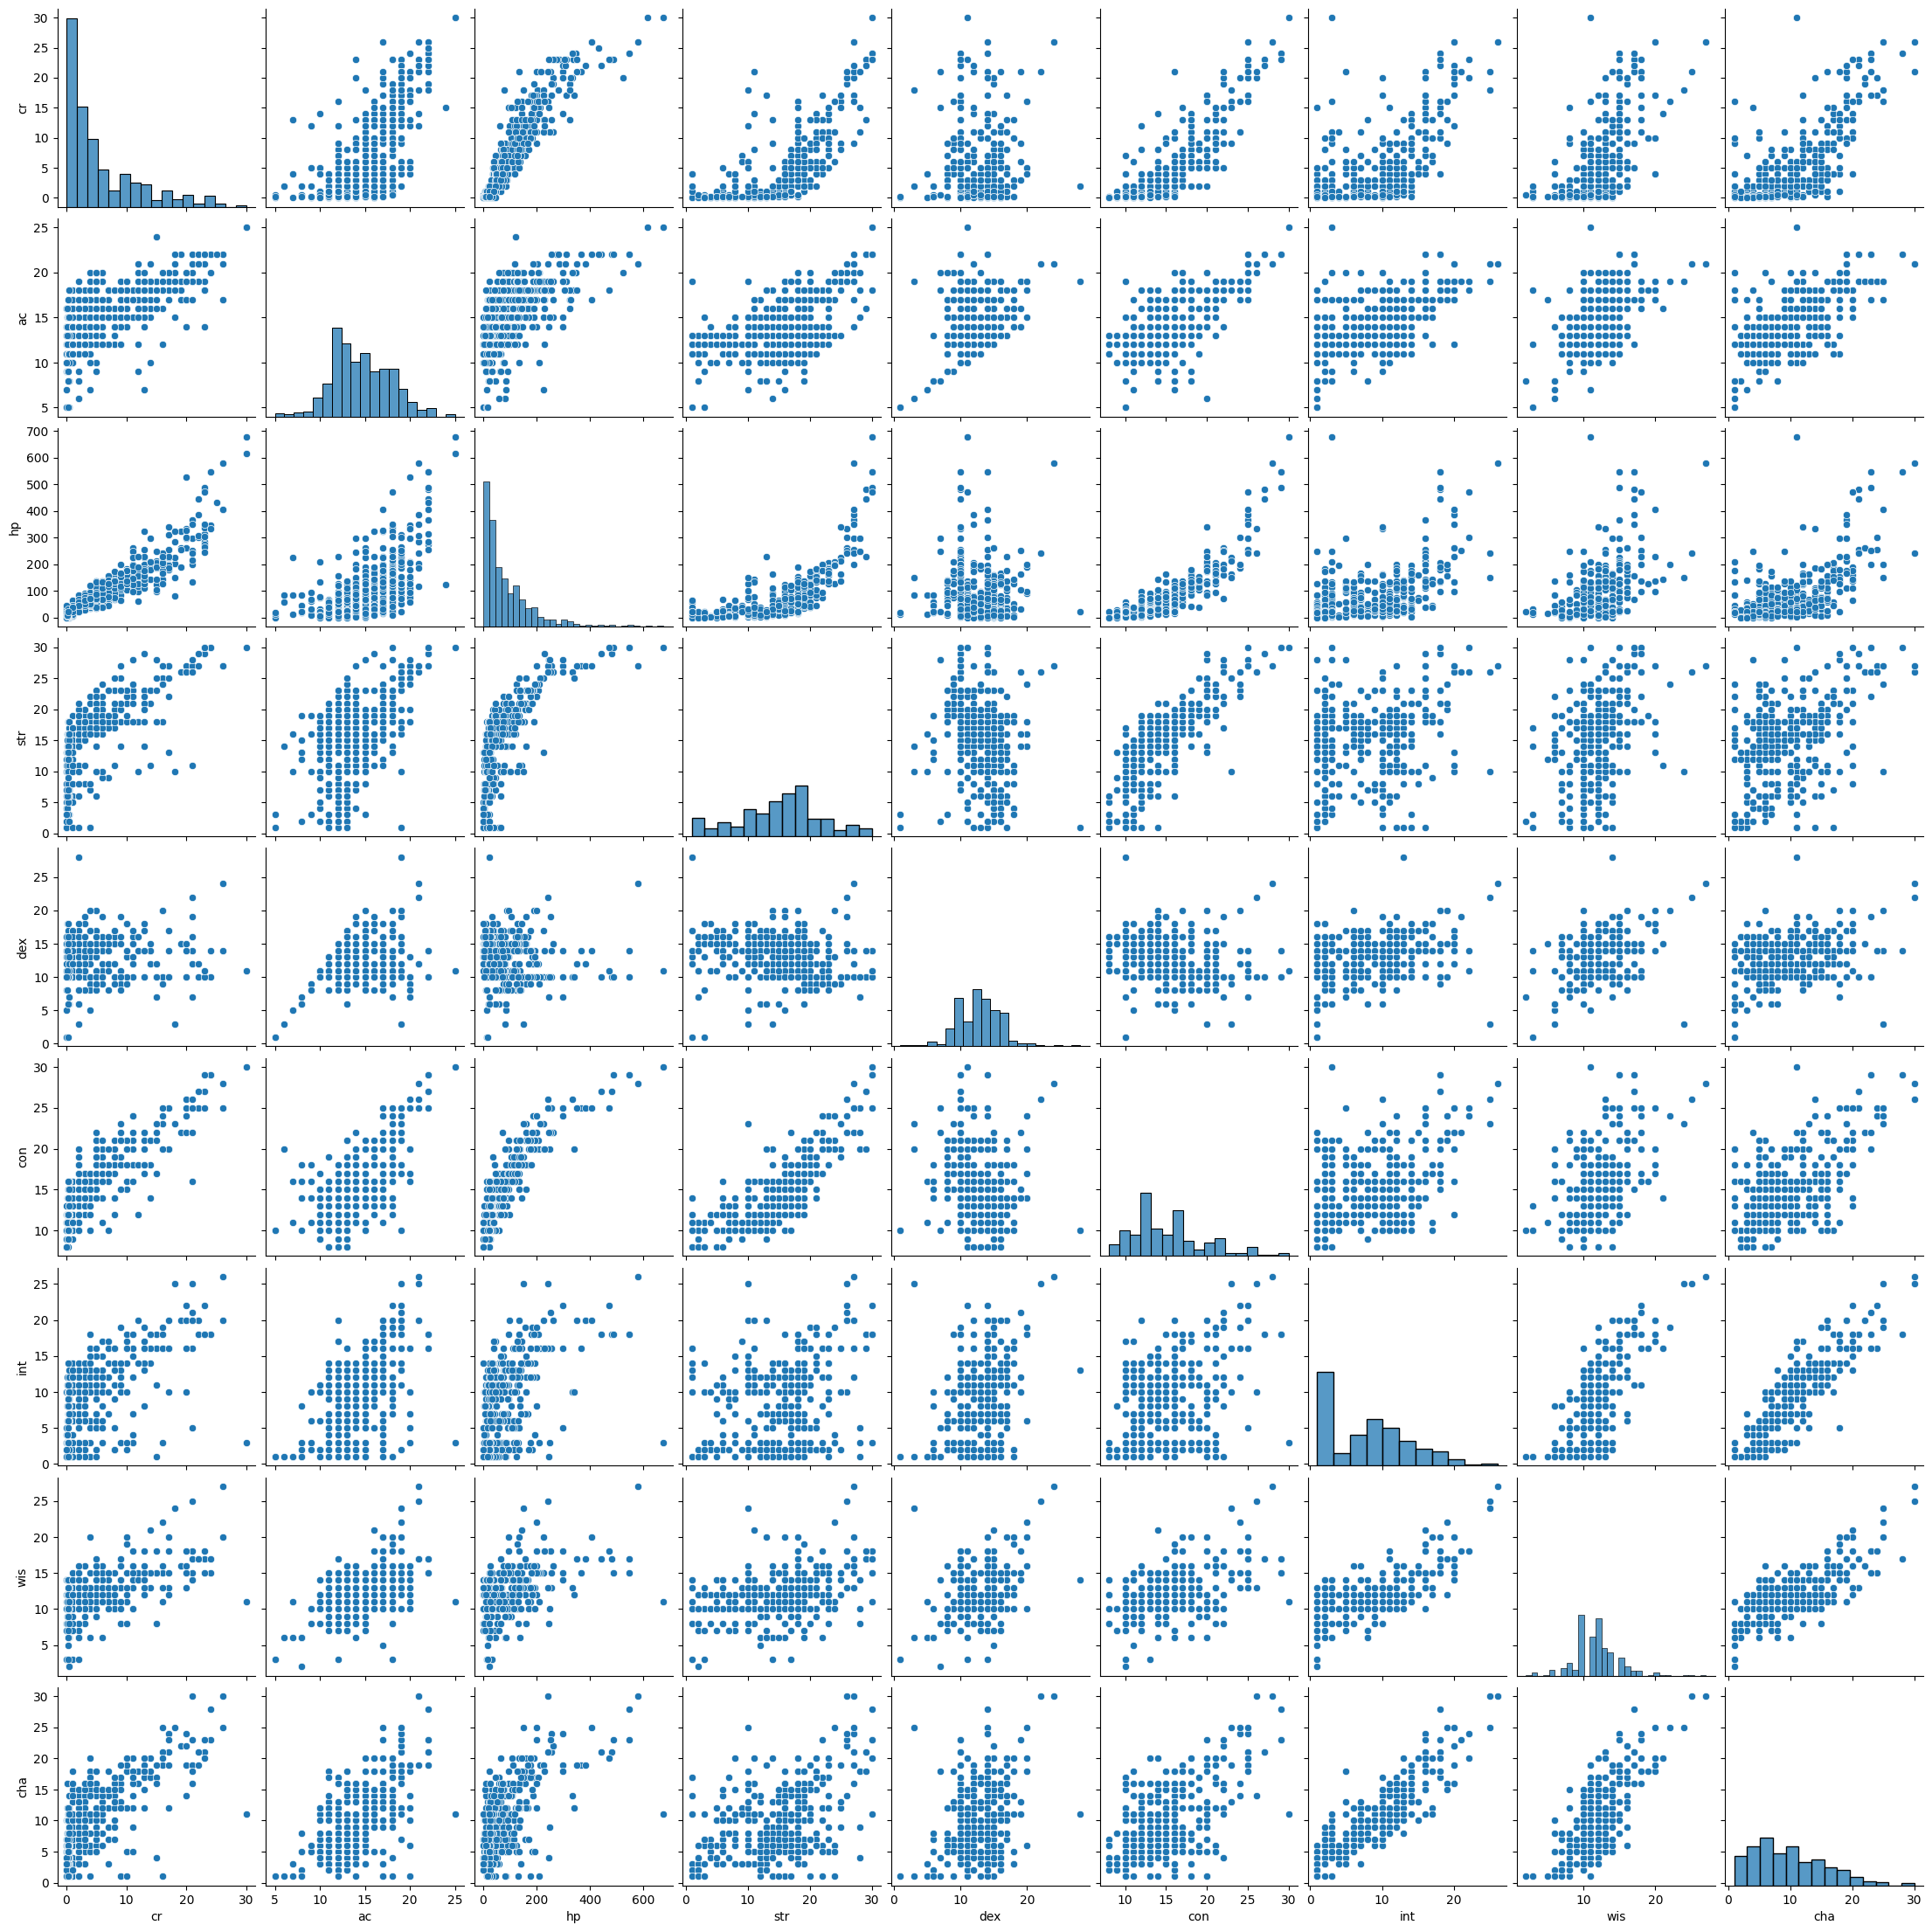

In [36]:
# from the looks of it this is actually all monsters from dnd
# we have way more data on low levels (low cr), which could be an issue but we can just weed out some of it
# also a note on low level data: CR is integers, EXCEPT between 0 and 1 where it can take on a few other values
# this means that there are simply more CR categories in that area making the spike look really big comparetively


# this first pairplot will be huge, but we are only interested in the first column to see how it changes through levels
sns.pairplot(df)

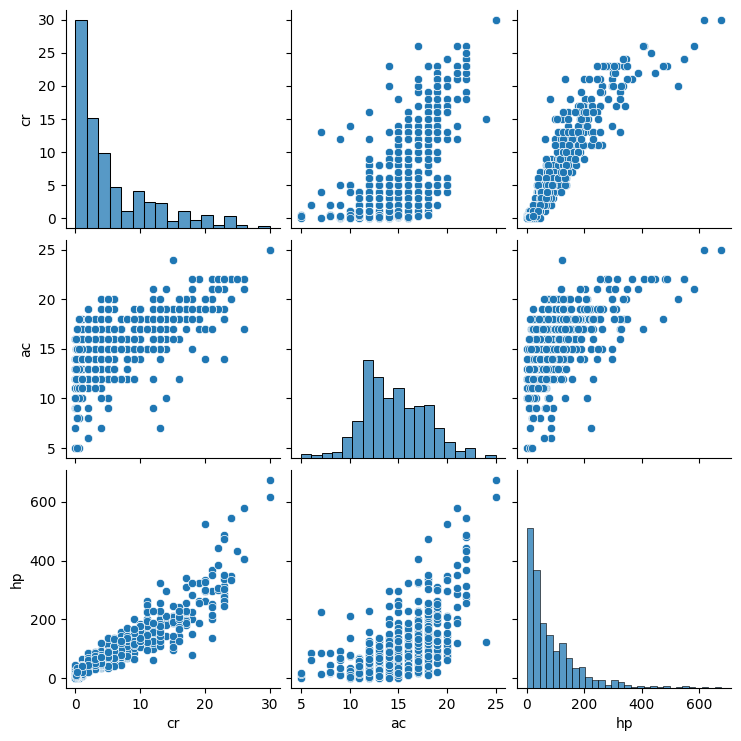

In [37]:
# let's see just the core statistics for a second
sns.pairplot(df[['cr', 'ac', 'hp']])

In [38]:
# we can se that hp is quite nice and linear while the ac is a bit too spread and probably won't land us good results
# let's split our data up for training and testing
# we'll use cr as the support variable while hp as target variable
sup_var = df[['cr']]
tar_var = df['hp']

sup_train, sup_test, tar_train, tar_test = train_test_split(sup_var, tar_var, test_size= 0.3)
# for now I'm leaving the seed random as I don't need it to be stable yet and can help find problems

In [39]:
# let's get our model ready and fit it
model_hp = LinearRegression()
model_hp.fit(sup_train, tar_train)

LinearRegression()

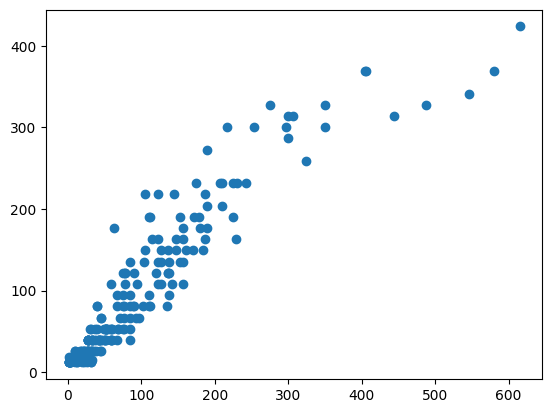

In [40]:
predictions = model_hp.predict(sup_test)
plt.scatter(tar_test, predictions)
plt.show()

In [41]:
# let's get actual numeric data on it's accuaricy

print(f"MAE\n{round(metrics.mean_absolute_error(tar_test, predictions), 2)}")
print(f"nMSE\n{round(metrics.mean_squared_error(tar_test, predictions), 2)}")
print(f"nR-squared\n{round(metrics.r2_score(tar_test, predictions), 2)}")

MAE
20.84
nMSE
1404.38
nR-squared
0.87


In [42]:
# while 0.85ish (moves around since we didn't fix the seed) r^2 might look a bit weak
# but since these values are not scientific and can warry based on a lot of factors like other abilities of a monster
# an 0.85 is actually a quite acceptable value, let's make a few tests with it
test_cr_s = [1, 2, 5, 7, 11, 20]
tester = {
    'cr': test_cr_s
}
tester = pd.DataFrame(tester)

In [43]:
result = model_hp.predict(tester)
result = zip(test_cr_s, result)
result = dict(result)
result


{1: np.float64(25.59969469879699),
 2: np.float64(39.321724226238366),
 5: np.float64(80.4878128085625),
 7: np.float64(107.93187186344524),
 11: np.float64(162.81998997321074),
 20: np.float64(286.3182557201831)}

In [58]:
# these results actually seem quite reasonable for the game and can work well for monster creation

# let's see how the model works if we try to get out AC or it's "con" (constitution), as that was quite linear as well
sup_var = df[['cr']]
sup_var_s = df_s[['cr']]
tar_ac_var = df['ac']
tar_con_var = df_s['con']

sup_train, sup_ac_test, tar_train, tar_ac_test = train_test_split(sup_var, tar_ac_var, test_size= 0.3)
model_ac = LinearRegression()
model_ac.fit(sup_train, tar_train)
sup_train, sup_con_test, tar_train, tar_con_test = train_test_split(sup_var_s, tar_con_var, test_size= 0.3)
model_con = LinearRegression()
model_con.fit(sup_train, tar_train)


LinearRegression()

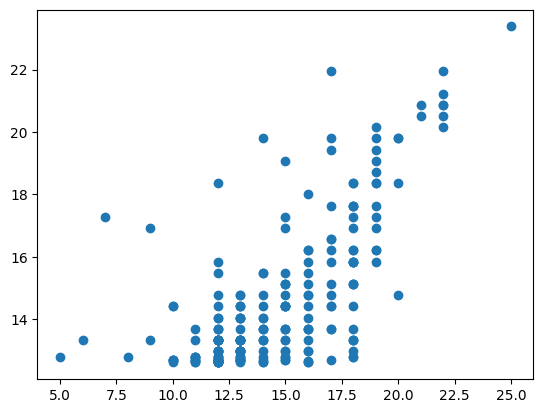

In [59]:
# let's see how they do, ac first, not expecting good results
predictions = model_ac.predict(sup_ac_test)
plt.scatter(tar_ac_test, predictions)
plt.show()

In [60]:
# as expected, not doing well

print(f"MAE\n{round(metrics.mean_absolute_error(tar_ac_test, predictions), 2)}")
print(f"nMSE\n{round(metrics.mean_squared_error(tar_ac_test, predictions), 2)}")
print(f"nR-squared\n{round(metrics.r2_score(tar_ac_test, predictions), 2)}")

MAE
1.65
nMSE
5.25
nR-squared
0.48


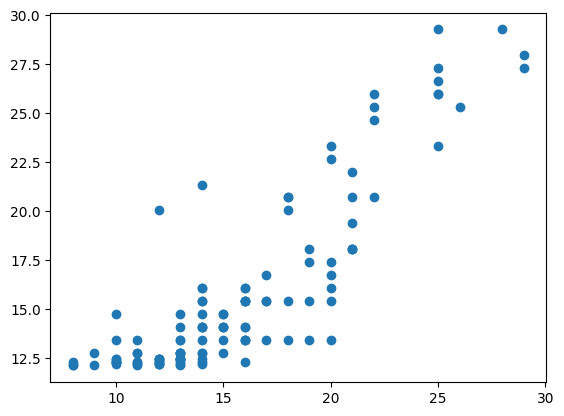

In [ ]:
# then constitution, my educated guess for this is around 0.65
predictions = model_con.predict(sup_con_test)
plt.scatter(tar_con_test, predictions)
plt.show()

In [63]:
print(f"MAE\n{round(metrics.mean_absolute_error(tar_con_test, predictions), 2)}")
print(f"nMSE\n{round(metrics.mean_squared_error(tar_con_test, predictions), 2)}")
print(f"nR-squared\n{round(metrics.r2_score(tar_con_test, predictions), 2)}")

MAE
1.85
nMSE
5.79
nR-squared
0.74


In [ ]:
# that actually looks quite alright, never expected a very precise outcome for this dataset but a 0.74(ish) seems pretty acceptable
